# below MCP of XGBoost，first fixed calibrate and test sets

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import numpy as np
import joblib


In [3]:
# Load the CSV file
testdata = pd.read_csv('testset_withVAEfeature.csv')
testdata

,ID,label,SMILES,VAE1,VAE2,VAE3,VAE4,VAE5,VAE6,VAE7,...,VAE55,VAE56,VAE57,VAE58,VAE59,VAE60,VAE61,VAE62,VAE63,VAE64
0,J589,1,CC(C=O)Cc1ccc(C(C)C)cc1,-1.944526,1.679953,-2.263069,-0.470525,0.249186,-0.840450,1.365574,...,0.522894,-0.039201,1.120057,0.136207,0.159887,1.323853,-1.276253,-1.177638,0.243265,-0.195218
1,J1020,0,NC(CSSCC(N)C(=O)O)C(=O)O,-3.410791,1.217956,-1.500174,0.101256,0.263797,-0.913054,-1.829050,...,0.191305,-1.181099,0.855936,-3.597098,0.463224,1.423725,-0.057817,-0.422255,1.216345,0.289866
2,J250,1,ON=C1C=CCCC1,-1.666891,0.953520,-1.672517,0.315652,-0.648014,-0.291091,0.389501,...,-0.211225,0.666869,0.596529,-0.059916,-0.255318,0.566586,-0.959209,-0.534034,-0.270522,-0.566854
3,J76,0,CC(=O)OC(C)(C)C1CC=C(C)CC1,-3.186931,0.622285,-2.414432,-0.635803,-0.072923,-0.484286,1.473655,...,0.746947,0.023469,0.416284,-0.534406,-0.604349,0.531837,-0.378896,-0.870354,0.940123,-0.181671
4,J176,0,CCOc1ccc(Cc2cc(C3OC(COC(C)=O)C(OC(C)=O)C(OC(C)...,0.031030,-3.868598,1.339807,-1.951870,4.852596,-1.260976,-1.811481,...,0.496465,-4.383767,3.121762,-4.385918,0.330981,0.293457,-2.612395,0.589794,-0.142610,5.131613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,J213,1,Cc1ccc(C(=O)CC(=O)C(F)(F)F)cc1,-2.142985,1.025706,-1.378746,0.639232,0.792939,-0.106582,1.040964,...,0.347639,-0.548521,0.731523,0.754265,0.188714,0.130322,-0.328275,-0.408736,1.311963,0.595509
280,A146A944,0,CC(C)C1=CC2=CCC3C(C)(CCCC34C(=O)OCC35CC4(C3)C5...,-1.367424,-4.310607,-3.082335,-2.644527,-2.127807,4.689502,4.298758,...,2.035690,-0.323320,2.185145,2.019897,-0.735776,-0.682104,0.799981,2.202062,-0.339645,1.797208
281,J1245,1,CC(CC(=O)Oc1ccc(S(=O)(=O)O)cc1)CC(C)(C)C,-2.589916,-0.475639,-0.434852,-0.548444,0.531704,-1.621847,1.475111,...,-1.120108,0.514395,0.869781,-1.917797,-0.470073,0.654162,0.268392,-0.284094,1.958162,1.006482
282,J562,1,Cc1ccc(S(=O)(=O)Cl)cc1,-1.470916,0.471982,-1.660401,0.372824,-0.023155,-1.554028,0.083367,...,-0.382380,-0.019765,0.813334,0.883805,0.429501,1.793369,-1.722793,-0.569235,1.684254,-0.541084


In [4]:
# Delete the "ID" and "Standard.SMILES" columns
testdata = testdata.drop(["ID", "SMILES"], axis=1)
testdata

,label,VAE1,VAE2,VAE3,VAE4,VAE5,VAE6,VAE7,VAE8,VAE9,...,VAE55,VAE56,VAE57,VAE58,VAE59,VAE60,VAE61,VAE62,VAE63,VAE64
0,1,-1.944526,1.679953,-2.263069,-0.470525,0.249186,-0.840450,1.365574,-0.930832,0.443654,...,0.522894,-0.039201,1.120057,0.136207,0.159887,1.323853,-1.276253,-1.177638,0.243265,-0.195218
1,0,-3.410791,1.217956,-1.500174,0.101256,0.263797,-0.913054,-1.829050,0.002801,0.235686,...,0.191305,-1.181099,0.855936,-3.597098,0.463224,1.423725,-0.057817,-0.422255,1.216345,0.289866
2,1,-1.666891,0.953520,-1.672517,0.315652,-0.648014,-0.291091,0.389501,-1.095691,-1.543393,...,-0.211225,0.666869,0.596529,-0.059916,-0.255318,0.566586,-0.959209,-0.534034,-0.270522,-0.566854
3,0,-3.186931,0.622285,-2.414432,-0.635803,-0.072923,-0.484286,1.473655,0.458000,-0.553194,...,0.746947,0.023469,0.416284,-0.534406,-0.604349,0.531837,-0.378896,-0.870354,0.940123,-0.181671
4,0,0.031030,-3.868598,1.339807,-1.951870,4.852596,-1.260976,-1.811481,1.305079,3.266316,...,0.496465,-4.383767,3.121762,-4.385918,0.330981,0.293457,-2.612395,0.589794,-0.142610,5.131613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,1,-2.142985,1.025706,-1.378746,0.639232,0.792939,-0.106582,1.040964,0.430662,0.887132,...,0.347639,-0.548521,0.731523,0.754265,0.188714,0.130322,-0.328275,-0.408736,1.311963,0.595509
280,0,-1.367424,-4.310607,-3.082335,-2.644527,-2.127807,4.689502,4.298758,4.170640,-0.350662,...,2.035690,-0.323320,2.185145,2.019897,-0.735776,-0.682104,0.799981,2.202062,-0.339645,1.797208
281,1,-2.589916,-0.475639,-0.434852,-0.548444,0.531704,-1.621847,1.475111,-0.260080,1.019365,...,-1.120108,0.514395,0.869781,-1.917797,-0.470073,0.654162,0.268392,-0.284094,1.958162,1.006482
282,1,-1.470916,0.471982,-1.660401,0.372824,-0.023155,-1.554028,0.083367,0.005263,-0.340143,...,-0.382380,-0.019765,0.813334,0.883805,0.429501,1.793369,-1.722793,-0.569235,1.684254,-0.541084


In [5]:
X_testdata = testdata.drop("label", axis=1)
y_testdata = testdata["label"]
y_testdata

0      1
1      0
2      1
3      0
4      0
      ..
279    1
280    0
281    1
282    1
283    0
Name: label, Length: 284, dtype: int64

In [6]:
# Encode the labels
le = LabelEncoder()
y_testdata = le.fit_transform(y_testdata)

In [7]:
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, average_precision_score, precision_recall_fscore_support
from sklearn.metrics import matthews_corrcoef
# Load the best model
best_model = joblib.load("XGboostbest_model.pkl")

# Use the model to predict on the test data
y_pred = best_model.predict(X_testdata)

# Get predicted probabilities
y_pred_proba = best_model.predict_proba(X_testdata)[:,1]

# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_testdata, y_pred).ravel()

# Calculate the sensitivity (also known as recall)
sensitivity = tp / (tp + fn)

# Calculate the specificity
specificity = tn / (tn + fp)

# Calculate the accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Calculate the MCC
mcc = matthews_corrcoef(y_testdata, y_pred)

# Calculate the F1 score
f1 = f1_score(y_testdata, y_pred)

# Calculate the ROC AUC score with probabilities
roc_auc = roc_auc_score(y_testdata, y_pred_proba)

# Calculate the PR AUC score
pr_auc = average_precision_score(y_testdata, y_pred_proba)

sensitivity, specificity, accuracy, mcc, f1, roc_auc, pr_auc


(0.6859504132231405,
 0.7852760736196319,
 0.7429577464788732,
 0.4728475390834904,
 0.694560669456067,
 0.8047964305633016,
 0.7621856690758672)

In [8]:
# Load the CSV file
calibratedata = pd.read_csv('calibrateset_withVAEfeature.csv')
calibratedata

,ID,label,SMILES,VAE1,VAE2,VAE3,VAE4,VAE5,VAE6,VAE7,...,VAE55,VAE56,VAE57,VAE58,VAE59,VAE60,VAE61,VAE62,VAE63,VAE64
0,A146A856,0,O=P(O)(C(F)(F)C(F)(F)C(F)(F)C(F)(F)F)C(F)(F)C(...,-6.297600,-0.822608,2.452361,-0.973581,6.483719,0.028990,-3.010179,...,-1.714819,-0.324293,7.400153,3.084848,-0.291137,-8.314127,0.249699,3.732142,0.412777,1.908427
1,J366,1,COc1cc(C)c2c(Oc3cccc(C(F)(F)F)c3)c(OC)cc([N+](...,0.529082,-1.445265,-1.143914,-1.435479,2.655970,0.472386,0.534045,...,0.372871,-0.312034,1.059776,1.374808,1.375413,-1.479548,0.255390,-2.243650,-0.729925,3.473336
2,J984,0,COc1ccc(Nc2ccc(CCNCC(O)c3ccc(O)c4[nH]c(=O)ccc3...,1.568929,-2.726032,5.142622,-1.201478,2.876397,0.048344,-4.289927,...,-0.762330,-0.764384,0.296737,-2.113058,3.116693,-3.642116,0.170152,-0.070952,-2.316049,5.211063
3,J1233,1,O=C(O)COc1cc(Cl)c(Cl)cc1Cl,-1.990606,0.037749,-1.960557,1.163630,0.312563,-0.930590,-0.930519,...,-0.447655,0.451342,0.210338,1.154542,1.097572,1.459506,0.199595,-0.599242,-0.955443,-0.131165
4,J748,1,CC(C)(c1ccc(OCC2CO2)cc1)c1ccc(OCC2CO2)cc1,-0.930183,-1.852474,0.481864,-1.038078,1.032902,2.464568,0.288785,...,1.990893,0.986807,-0.769798,0.481696,-0.007820,-1.945025,-1.718904,-0.639044,1.502226,1.076954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,J719,0,COc1ncc(F)c2nc(S(=O)(=O)Nc3c(F)cccc3F)nn12,0.184687,-0.873185,0.207525,-0.286027,0.467316,-0.721434,0.516907,...,-1.590053,1.627042,0.470458,2.711415,-0.379744,-2.500527,1.239445,0.401814,0.136007,1.794133
280,J1010,0,CN1C(=O)c2ccc3c4ccc5c6c(ccc(c7ccc(c2c37)C1=O)c...,3.521303,-2.799086,-6.011129,-4.288428,-0.999215,6.404498,1.464840,...,-0.061732,-2.774574,0.030254,4.881628,-3.806252,-2.175217,-1.807941,1.832099,-4.679526,4.787452
281,J669,0,CCCCCCCCNC(=O)Nc1ccc(Cc2ccc(NC(=O)NCCCCCCCC)cc...,-2.854196,-3.845268,8.141615,-3.648489,1.329216,-3.262791,-8.362792,...,-2.064050,-2.920292,4.253309,-9.365771,3.795737,-4.039011,0.278838,3.232860,-1.071337,5.643922
282,J923,1,CCCCCCCCCCCCCCCCCCCCBr,-7.333440,-1.302337,0.327452,-5.243084,-1.552685,-5.003287,-3.593447,...,-3.039089,-0.804090,4.343425,-3.680332,3.348496,-2.611673,0.869662,0.758130,-0.610623,-0.077603


In [9]:
# Delete the "ID" and "Standard.SMILES" columns
calibratedata = calibratedata.drop(["ID", "SMILES"], axis=1)
calibratedata

,label,VAE1,VAE2,VAE3,VAE4,VAE5,VAE6,VAE7,VAE8,VAE9,...,VAE55,VAE56,VAE57,VAE58,VAE59,VAE60,VAE61,VAE62,VAE63,VAE64
0,0,-6.297600,-0.822608,2.452361,-0.973581,6.483719,0.028990,-3.010179,-0.891376,1.927723,...,-1.714819,-0.324293,7.400153,3.084848,-0.291137,-8.314127,0.249699,3.732142,0.412777,1.908427
1,1,0.529082,-1.445265,-1.143914,-1.435479,2.655970,0.472386,0.534045,-0.267281,2.702775,...,0.372871,-0.312034,1.059776,1.374808,1.375413,-1.479548,0.255390,-2.243650,-0.729925,3.473336
2,0,1.568929,-2.726032,5.142622,-1.201478,2.876397,0.048344,-4.289927,-1.223377,3.506333,...,-0.762330,-0.764384,0.296737,-2.113058,3.116693,-3.642116,0.170152,-0.070952,-2.316049,5.211063
3,1,-1.990606,0.037749,-1.960557,1.163630,0.312563,-0.930590,-0.930519,-0.822144,1.483149,...,-0.447655,0.451342,0.210338,1.154542,1.097572,1.459506,0.199595,-0.599242,-0.955443,-0.131165
4,1,-0.930183,-1.852474,0.481864,-1.038078,1.032902,2.464568,0.288785,0.848040,1.241403,...,1.990893,0.986807,-0.769798,0.481696,-0.007820,-1.945025,-1.718904,-0.639044,1.502226,1.076954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,0,0.184687,-0.873185,0.207525,-0.286027,0.467316,-0.721434,0.516907,-0.029226,1.671207,...,-1.590053,1.627042,0.470458,2.711415,-0.379744,-2.500527,1.239445,0.401814,0.136007,1.794133
280,0,3.521303,-2.799086,-6.011129,-4.288428,-0.999215,6.404498,1.464840,6.999261,0.090455,...,-0.061732,-2.774574,0.030254,4.881628,-3.806252,-2.175217,-1.807941,1.832099,-4.679526,4.787452
281,0,-2.854196,-3.845268,8.141615,-3.648489,1.329216,-3.262791,-8.362792,-5.200621,3.133582,...,-2.064050,-2.920292,4.253309,-9.365771,3.795737,-4.039011,0.278838,3.232860,-1.071337,5.643922
282,1,-7.333440,-1.302337,0.327452,-5.243084,-1.552685,-5.003287,-3.593447,-1.870519,-0.432513,...,-3.039089,-0.804090,4.343425,-3.680332,3.348496,-2.611673,0.869662,0.758130,-0.610623,-0.077603


In [10]:
X_calibratedata = calibratedata.drop("label", axis=1)
y_calibratedata = calibratedata["label"]
y_calibratedata

0      0
1      1
2      0
3      1
4      1
      ..
279    0
280    0
281    0
282    1
283    1
Name: label, Length: 284, dtype: int64

In [11]:
# Encode the labels
le = LabelEncoder()
y_calibratedata = le.fit_transform(y_calibratedata)

In [12]:
y_calibratedata

array([0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1],
      dtype=int64)

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import recall_score

#Split data into training, calibration and testing datasets


X_calib=X_calibratedata
y_calib=y_calibratedata
X_test=X_testdata
y_test=y_testdata

# Train a RandomForestClassifier (or any other classifier)
clf = joblib.load("XGboostbest_model.pkl")

# Apply the classifier to the calibration set and calculate p-values
y_pred_proba_calib = clf.predict_proba(X_calib)
y_pred_proba_test = clf.predict_proba(X_test)

# Calculate the conformity scores
conformity_scores = y_pred_proba_calib[np.arange(len(y_calib)), y_calib]

# Calculate p-values for test set
p_values = []
for probas in y_pred_proba_test:
    instance_p_values = [np.mean(proba >= conformity_scores) for proba in probas]
    p_values.append(instance_p_values)
p_values = np.array(p_values)
alpha=0.7

# Make predictions
predictions = [(p > alpha).nonzero()[0] for p in p_values]

def calculate_metrics_and_accuracy(y_true, y_pred_binary, y_pred_proba):
    # Calculate Accuracy
    accuracy = np.sum(y_pred_binary == y_true) / len(y_true)
    
    # Calculate Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_true, y_pred_binary)

    # Calculate Sensitivity
    sensitivity = recall_score(y_true, y_pred_binary)

    # Calculate Specificity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    specificity = tn / (tn+fp)

    # Calculate ROC AUC
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    # Calculate PR AUC
    pr_auc = average_precision_score(y_true, y_pred_proba)

    print(f'Accuracy: {accuracy}')
    print(f'Matthews Correlation Coefficient: {mcc}')
    print(f'Sensitivity: {sensitivity}')
    print(f'Specificity: {specificity}')
    print(f'ROC AUC: {roc_auc}')
    print(f'PR AUC: {pr_auc}')

# Convert probabilities into binary outputs for all predictions
y_pred_test_binary = np.argmax(y_pred_proba_test, axis=1)

# Calculate metrics for all predictions
print("Metrics for all predictions:")
calculate_metrics_and_accuracy(y_test, y_pred_test_binary, y_pred_proba_test[:, 1])

# Filter out uncertain predictions
filtered_indices = [i for i, prediction in enumerate(predictions) if len(prediction) == 1]

# Calculate metrics for filtered predictions
filtered_y_test = y_test[filtered_indices]
filtered_y_pred_proba = y_pred_proba_test[filtered_indices, 1]
filtered_y_pred_binary = [predictions[i][0] for i in filtered_indices]

print("\nMetrics for filtered predictions:")
calculate_metrics_and_accuracy(filtered_y_test, filtered_y_pred_binary, filtered_y_pred_proba)


Metrics for all predictions:
Accuracy: 0.7429577464788732
Matthews Correlation Coefficient: 0.4728475390834904
Sensitivity: 0.6859504132231405
Specificity: 0.7852760736196319
ROC AUC: 0.8047964305633016
PR AUC: 0.7621856690758672

Metrics for filtered predictions:
Accuracy: 0.8888888888888888
Matthews Correlation Coefficient: 0.7537187825081647
Sensitivity: 0.7714285714285715
Specificity: 0.953125
ROC AUC: 0.9276785714285714
PR AUC: 0.9088008065316773


In [15]:
len(filtered_indices)/len(y_test)

0.3485915492957746

## Accuracy 

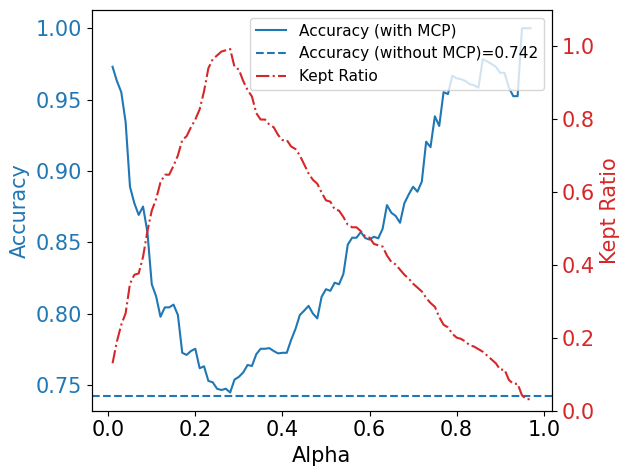

In [16]:
import matplotlib.pyplot as plt

alphas = np.arange(0.01, 0.98, 0.01)
filtered_accuracies = []
filtered_lengths = []  # Stores the lengths of filtered_y_test

# The loop and the operations for calculating the filtered_accuracies and filtered_lengths

for alpha in alphas:
    predictions = [(p > alpha).nonzero()[0] for p in p_values]
    filtered_indices = [i for i, prediction in enumerate(predictions) if len(prediction) == 1]
    filtered_y_test = y_test[filtered_indices]
    filtered_predictions = [predictions[i][0] for i in filtered_indices]
    correct = np.sum(filtered_y_test == filtered_predictions)
    filtered_accuracy = correct / len(filtered_y_test)
    
    filtered_accuracies.append(filtered_accuracy)
    filtered_lengths.append(len(filtered_y_test))  # Add the length to the list


    
divisor = len(y_test)  # replace with the number you want to divide by

filtered_lengths = [n / divisor for n in filtered_lengths]    
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Alpha',fontsize=15)
ax1.set_ylabel('Accuracy', color=color,fontsize=15)
line1, = ax1.plot(alphas, filtered_accuracies, color=color, label='Accuracy (with MCP)')
ax1.tick_params(axis='y', labelcolor=color, labelsize=15)
line2 = ax1.axhline(y=0.742, color='tab:blue', linestyle='--', label='Accuracy (without MCP)=0.742') # Add horizontal line

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylim([0, 1.1])
color = 'tab:red'
ax2.set_ylabel('Kept Ratio', color=color,fontsize=15)  # we already handled the x-label with ax1
line3, = ax2.plot(alphas, filtered_lengths, color=color, linestyle='-.', label='Kept Ratio')
ax2.tick_params(axis='y', labelcolor=color, labelsize=15)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

# Setting the legend inside the plot. loc='upper right' or 'lower right' or 'upper left' or 'lower left' are common choices.
# bbox_to_anchor can be used to specify the exact coordinates for the legend.
plt.legend(handles=[line1, line2, line3], loc='upper right', fontsize=11) 

# Saving the figure as a PDF. You can replace 'output.pdf' with your desired filename. 
# set the size of the labels on the x-axis
ax1.tick_params(axis='x', labelsize=15)
plt.savefig('accuracyMCP.pdf', format='pdf')

plt.show()

## MCC 

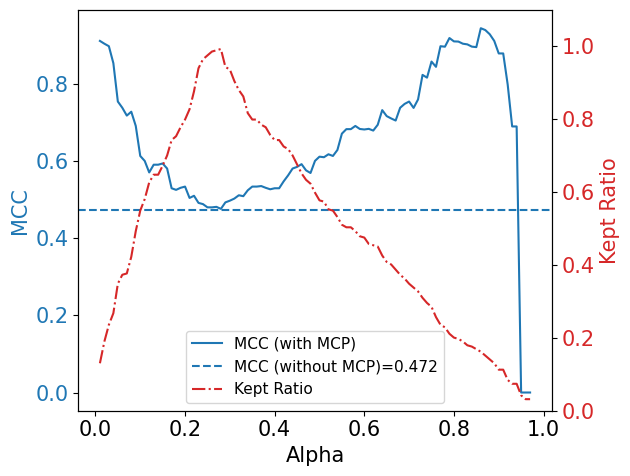

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import matthews_corrcoef
import numpy as np

alphas = np.arange(0.01, 0.98, 0.01)
filtered_MCCs = []
filtered_lengths = []  # Stores the lengths of filtered_y_test

# The loop and the operations for calculating the filtered_MCCs and filtered_lengths
for alpha in alphas:
    predictions = [(p > alpha).nonzero()[0] for p in p_values]
    filtered_indices = [i for i, prediction in enumerate(predictions) if len(prediction) == 1]
    filtered_y_test = y_test[filtered_indices]
    filtered_predictions = [predictions[i][0] for i in filtered_indices]
    MCC = matthews_corrcoef(filtered_y_test, filtered_predictions)
    
    filtered_MCCs.append(MCC)
    filtered_lengths.append(len(filtered_y_test))  # Add the length to the list

divisor = len(y_test)  # replace with the number you want to divide by
filtered_lengths = [n / divisor for n in filtered_lengths]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Alpha',fontsize=15)
ax1.set_ylabel('MCC', color=color,fontsize=15)
line1, = ax1.plot(alphas, filtered_MCCs, color=color, label='MCC (with MCP)')
ax1.tick_params(axis='y', labelcolor=color, labelsize=15)
line2 = ax1.axhline(y=0.472, color='tab:blue', linestyle='--', label='MCC (without MCP)=0.472') # Add horizontal line

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylim([0, 1.1])
color = 'tab:red'
ax2.set_ylabel('Kept Ratio', color=color,fontsize=15)  # we already handled the x-label with ax1
line3, = ax2.plot(alphas, filtered_lengths, color=color, linestyle='-.', label='Kept Ratio')
ax2.tick_params(axis='y', labelcolor=color, labelsize=15)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

# Setting the legend inside the plot. loc='upper right' or 'lower right' or 'upper left' or 'lower left' are common choices.
plt.legend(handles=[line1, line2,line3], loc='lower center', fontsize=11) 
ax1.tick_params(axis='x', labelsize=15)
# Saving the figure as a PDF. You can replace 'output.pdf' with your desired filename. 
plt.savefig('MCC_MCP.pdf', format='pdf')

plt.show()


## Sensitivity 

C:\Users\Localadmin_weikaixi\anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Localadmin_weikaixi\anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Localadmin_weikaixi\anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


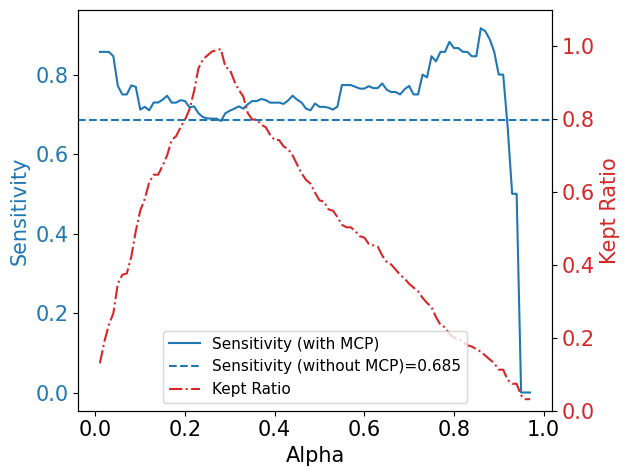

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
import numpy as np

alphas = np.arange(0.01, 0.98, 0.01)
filtered_sensitivity = []
filtered_lengths = []  # Stores the lengths of filtered_y_test

# The loop and the operations for calculating the filtered_sensitivity and filtered_lengths
for alpha in alphas:
    predictions = [(p > alpha).nonzero()[0] for p in p_values]
    filtered_indices = [i for i, prediction in enumerate(predictions) if len(prediction) == 1]
    filtered_y_test = y_test[filtered_indices]
    filtered_predictions = [predictions[i][0] for i in filtered_indices]
    sensitivity = recall_score(filtered_y_test, filtered_predictions)
    
    filtered_sensitivity.append(sensitivity)
    filtered_lengths.append(len(filtered_y_test))  # Add the length to the list

divisor = len(y_test)  # replace with the number you want to divide by
filtered_lengths = [n / divisor for n in filtered_lengths]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Alpha',fontsize=15)
ax1.set_ylabel('Sensitivity', color=color,fontsize=15)
line1, = ax1.plot(alphas, filtered_sensitivity, color=color, label='Sensitivity (with MCP)')
ax1.tick_params(axis='y', labelcolor=color, labelsize=15)
line2 = ax1.axhline(y=0.685, color='tab:blue', linestyle='--', label='Sensitivity (without MCP)=0.685') # Add horizontal line

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylim([0, 1.1])
color = 'tab:red'
ax2.set_ylabel('Kept Ratio', color=color,fontsize=15)  # we already handled the x-label with ax1
line3, = ax2.plot(alphas, filtered_lengths, color=color, linestyle='-.', label='Kept Ratio')
ax2.tick_params(axis='y', labelcolor=color, labelsize=15)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

# Setting the legend inside the plot. loc='upper right' or 'lower right' or 'upper left' or 'lower left' are common choices.
plt.legend(handles=[line1, line2, line3], loc='lower center', fontsize=11) 
ax1.tick_params(axis='x', labelsize=15)
# Saving the figure as a PDF. You can replace 'output.pdf' with your desired filename. 
plt.savefig('sensitivity_MCP.pdf', format='pdf')

plt.show()


## Specificity

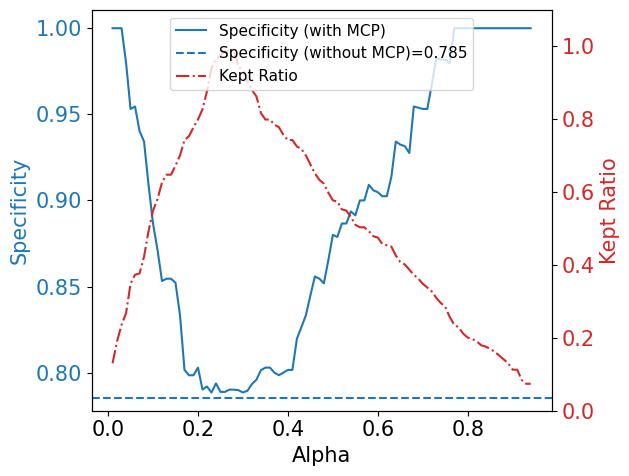

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn+fp)
    return specificity

alphas = np.arange(0.01, 0.95, 0.01)
filtered_specificity = []
filtered_lengths = []  # Stores the lengths of filtered_y_test

# The loop and the operations for calculating the filtered_specificity and filtered_lengths
for alpha in alphas:
    predictions = [(p > alpha).nonzero()[0] for p in p_values]
    filtered_indices = [i for i, prediction in enumerate(predictions) if len(prediction) == 1]
    filtered_y_test = y_test[filtered_indices]
    filtered_predictions = [predictions[i][0] for i in filtered_indices]
    specificity = specificity_score(filtered_y_test, filtered_predictions)
    
    filtered_specificity.append(specificity)
    filtered_lengths.append(len(filtered_y_test))  # Add the length to the list

divisor = len(y_test)  # replace with the number you want to divide by
filtered_lengths = [n / divisor for n in filtered_lengths]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Alpha',fontsize=15)
ax1.set_ylabel('Specificity', color=color,fontsize=15)
line1, = ax1.plot(alphas, filtered_specificity, color=color, label='Specificity (with MCP)')
ax1.tick_params(axis='y', labelcolor=color, labelsize=15)
line2 = ax1.axhline(y=0.785, color='tab:blue', linestyle='--', label='Specificity (without MCP)=0.785') # Add horizontal line

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylim([0, 1.1])
color = 'tab:red'
ax2.set_ylabel('Kept Ratio', color=color,fontsize=15)  # we already handled the x-label with ax1
line3, = ax2.plot(alphas, filtered_lengths, color=color, linestyle='-.', label='Kept Ratio')
ax2.tick_params(axis='y', labelcolor=color, labelsize=15)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

# Setting the legend inside the plot. loc='upper right' or 'lower right' or 'upper left' or 'lower left' are common choices.
plt.legend(handles=[line1, line2, line3], loc='upper center', fontsize=11) 
ax1.tick_params(axis='x', labelsize=15)
# Saving the figure as a PDF. You can replace 'output.pdf' with your desired filename. 
plt.savefig('specificity_MCP.pdf', format='pdf')

plt.show()


## ROCAUC 

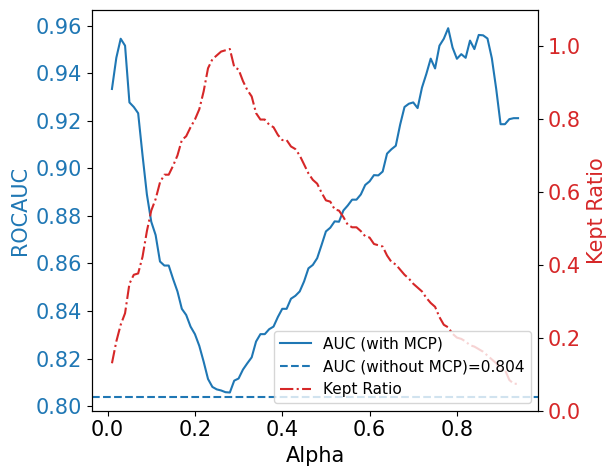

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import numpy as np

alphas = np.arange(0.01, 0.95, 0.01)
filtered_auc = []
filtered_lengths = []  # Stores the lengths of filtered_y_test

# Make sure to define or replace X_calib, y_calib, X_test, y_test with your actual data

test_probabilities = clf.predict_proba(X_test) # calculate predicted probabilities for the test data

# The loop and the operations for calculating the filtered_auc and filtered_lengths
for alpha in alphas:
    

    
    predictions = [(p > alpha).nonzero()[0] for p in p_values]
    filtered_indices = [i for i, prediction in enumerate(predictions) if len(prediction) == 1]
    #filtered_predictions = [predictions[i][0] for i in filtered_indices]
    
    filtered_y_test = y_test[filtered_indices]
    filtered_test_probabilities = test_probabilities[filtered_indices][:,1] # here, we are assuming that '1' is the positive class.
    auc = roc_auc_score(filtered_y_test, filtered_test_probabilities)
    
    filtered_auc.append(auc)
    filtered_lengths.append(len(filtered_y_test))  # Add the length to the list


    
    
divisor = len(y_test)  # replace with the number you want to divide by
filtered_lengths = [n / divisor for n in filtered_lengths]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Alpha',fontsize=15)
ax1.set_ylabel('ROCAUC', color=color,fontsize=15)
line1, = ax1.plot(alphas, filtered_auc, color=color, label='AUC (with MCP)')
ax1.tick_params(axis='y', labelcolor=color, labelsize=15)
line2 = ax1.axhline(y=0.804, color='tab:blue', linestyle='--', label='AUC (without MCP)=0.804')  # Add horizontal line

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylim([0, 1.1])
color = 'tab:red'
ax2.set_ylabel('Kept Ratio', color=color,fontsize=15)  # we already handled the x-label with ax1
line3, = ax2.plot(alphas, filtered_lengths, color=color, linestyle='-.', label='Kept Ratio')
ax2.tick_params(axis='y', labelcolor=color, labelsize=15)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

# Setting the legend inside the plot. loc='upper right' or 'lower right' or 'upper left' or 'lower left' are common choices.
plt.legend(handles=[line1, line2, line3], loc='lower right', fontsize=11) 
ax1.tick_params(axis='x', labelsize=15)
# Saving the figure as a PDF. You can replace 'output.pdf' with your desired filename. 
plt.savefig('AUC_MCP.pdf', format='pdf')

plt.show()


## PRAUC 

In [22]:
import sklearn

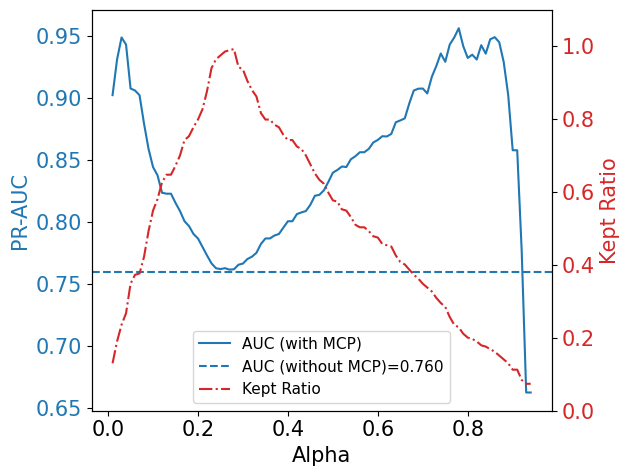

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
import numpy as np
from sklearn.metrics import precision_recall_curve

alphas = np.arange(0.01, 0.95, 0.01)
filtered_prauc = []
filtered_lengths = []  # Stores the lengths of filtered_y_test

# Make sure to define or replace X_calib, y_calib, X_test, y_test with your actual data

test_probabilities = clf.predict_proba(X_test) # calculate predicted probabilities for the test data

# The loop and the operations for calculating the filtered_prauc and filtered_lengths
for alpha in alphas:
    predictions = [(p > alpha).nonzero()[0] for p in p_values]
    filtered_indices = [i for i, prediction in enumerate(predictions) if len(prediction) == 1]

    filtered_y_test = y_test[filtered_indices]
    filtered_test_probabilities = test_probabilities[filtered_indices, 1]  # here, we are assuming that '1' is the positive class.
    
    
    
    
    # Calculate precision-recall curve
    precision, recall, _ = precision_recall_curve(filtered_y_test, filtered_test_probabilities)

    # Calculate the AUC-PR
    prauc = sklearn.metrics.auc(recall, precision)
    
    filtered_prauc.append(prauc)
    filtered_lengths.append(len(filtered_y_test))  # Add the length to the list

divisor = len(y_test)  # replace with the number you want to divide by
filtered_lengths = [n / divisor for n in filtered_lengths]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Alpha', fontsize=15)
ax1.set_ylabel('PR-AUC', color=color, fontsize=15)
line1, = ax1.plot(alphas, filtered_prauc, color=color, label='AUC (with MCP)')
ax1.tick_params(axis='y', labelcolor=color, labelsize=15)
line2 = ax1.axhline(y=0.760, color='tab:blue', linestyle='--', label='AUC (without MCP)=0.760')  # Add horizontal line

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylim([0, 1.1])
color = 'tab:red'
ax2.set_ylabel('Kept Ratio', color=color, fontsize=15)  # we already handled the x-label with ax1
line3, = ax2.plot(alphas, filtered_lengths, color=color, linestyle='-.', label='Kept Ratio')
ax2.tick_params(axis='y', labelcolor=color, labelsize=15)

fig.tight_layout()  # otherwise the right y-label is slightly clipped

# Setting the legend inside the plot. loc='upper right' or 'lower right' or 'upper left' or 'lower left' are common choices.
plt.legend(handles=[line1, line2, line3], loc='lower center', fontsize=11) 
ax1.tick_params(axis='x', labelsize=15)
# Saving the figure as a PDF. You can replace 'output.pdf' with your desired filename. 
plt.savefig('PR_AUC_MCP.pdf', format='pdf')

plt.show()


# below is MCP with regroup

In [25]:
# Load the CSV file
testdata = pd.read_csv('testset_withVAEfeature.csv')
testdata

,ID,label,SMILES,VAE1,VAE2,VAE3,VAE4,VAE5,VAE6,VAE7,...,VAE55,VAE56,VAE57,VAE58,VAE59,VAE60,VAE61,VAE62,VAE63,VAE64
0,J589,1,CC(C=O)Cc1ccc(C(C)C)cc1,-1.944526,1.679953,-2.263069,-0.470525,0.249186,-0.840450,1.365574,...,0.522894,-0.039201,1.120057,0.136207,0.159887,1.323853,-1.276253,-1.177638,0.243265,-0.195218
1,J1020,0,NC(CSSCC(N)C(=O)O)C(=O)O,-3.410791,1.217956,-1.500174,0.101256,0.263797,-0.913054,-1.829050,...,0.191305,-1.181099,0.855936,-3.597098,0.463224,1.423725,-0.057817,-0.422255,1.216345,0.289866
2,J250,1,ON=C1C=CCCC1,-1.666891,0.953520,-1.672517,0.315652,-0.648014,-0.291091,0.389501,...,-0.211225,0.666869,0.596529,-0.059916,-0.255318,0.566586,-0.959209,-0.534034,-0.270522,-0.566854
3,J76,0,CC(=O)OC(C)(C)C1CC=C(C)CC1,-3.186931,0.622285,-2.414432,-0.635803,-0.072923,-0.484286,1.473655,...,0.746947,0.023469,0.416284,-0.534406,-0.604349,0.531837,-0.378896,-0.870354,0.940123,-0.181671
4,J176,0,CCOc1ccc(Cc2cc(C3OC(COC(C)=O)C(OC(C)=O)C(OC(C)...,0.031030,-3.868598,1.339807,-1.951870,4.852596,-1.260976,-1.811481,...,0.496465,-4.383767,3.121762,-4.385918,0.330981,0.293457,-2.612395,0.589794,-0.142610,5.131613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,J213,1,Cc1ccc(C(=O)CC(=O)C(F)(F)F)cc1,-2.142985,1.025706,-1.378746,0.639232,0.792939,-0.106582,1.040964,...,0.347639,-0.548521,0.731523,0.754265,0.188714,0.130322,-0.328275,-0.408736,1.311963,0.595509
280,A146A944,0,CC(C)C1=CC2=CCC3C(C)(CCCC34C(=O)OCC35CC4(C3)C5...,-1.367424,-4.310607,-3.082335,-2.644527,-2.127807,4.689502,4.298758,...,2.035690,-0.323320,2.185145,2.019897,-0.735776,-0.682104,0.799981,2.202062,-0.339645,1.797208
281,J1245,1,CC(CC(=O)Oc1ccc(S(=O)(=O)O)cc1)CC(C)(C)C,-2.589916,-0.475639,-0.434852,-0.548444,0.531704,-1.621847,1.475111,...,-1.120108,0.514395,0.869781,-1.917797,-0.470073,0.654162,0.268392,-0.284094,1.958162,1.006482
282,J562,1,Cc1ccc(S(=O)(=O)Cl)cc1,-1.470916,0.471982,-1.660401,0.372824,-0.023155,-1.554028,0.083367,...,-0.382380,-0.019765,0.813334,0.883805,0.429501,1.793369,-1.722793,-0.569235,1.684254,-0.541084


In [26]:
# Delete the "ID" and "Standard.SMILES" columns
testdata = testdata.drop(["ID", "SMILES"], axis=1)
testdata

,label,VAE1,VAE2,VAE3,VAE4,VAE5,VAE6,VAE7,VAE8,VAE9,...,VAE55,VAE56,VAE57,VAE58,VAE59,VAE60,VAE61,VAE62,VAE63,VAE64
0,1,-1.944526,1.679953,-2.263069,-0.470525,0.249186,-0.840450,1.365574,-0.930832,0.443654,...,0.522894,-0.039201,1.120057,0.136207,0.159887,1.323853,-1.276253,-1.177638,0.243265,-0.195218
1,0,-3.410791,1.217956,-1.500174,0.101256,0.263797,-0.913054,-1.829050,0.002801,0.235686,...,0.191305,-1.181099,0.855936,-3.597098,0.463224,1.423725,-0.057817,-0.422255,1.216345,0.289866
2,1,-1.666891,0.953520,-1.672517,0.315652,-0.648014,-0.291091,0.389501,-1.095691,-1.543393,...,-0.211225,0.666869,0.596529,-0.059916,-0.255318,0.566586,-0.959209,-0.534034,-0.270522,-0.566854
3,0,-3.186931,0.622285,-2.414432,-0.635803,-0.072923,-0.484286,1.473655,0.458000,-0.553194,...,0.746947,0.023469,0.416284,-0.534406,-0.604349,0.531837,-0.378896,-0.870354,0.940123,-0.181671
4,0,0.031030,-3.868598,1.339807,-1.951870,4.852596,-1.260976,-1.811481,1.305079,3.266316,...,0.496465,-4.383767,3.121762,-4.385918,0.330981,0.293457,-2.612395,0.589794,-0.142610,5.131613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,1,-2.142985,1.025706,-1.378746,0.639232,0.792939,-0.106582,1.040964,0.430662,0.887132,...,0.347639,-0.548521,0.731523,0.754265,0.188714,0.130322,-0.328275,-0.408736,1.311963,0.595509
280,0,-1.367424,-4.310607,-3.082335,-2.644527,-2.127807,4.689502,4.298758,4.170640,-0.350662,...,2.035690,-0.323320,2.185145,2.019897,-0.735776,-0.682104,0.799981,2.202062,-0.339645,1.797208
281,1,-2.589916,-0.475639,-0.434852,-0.548444,0.531704,-1.621847,1.475111,-0.260080,1.019365,...,-1.120108,0.514395,0.869781,-1.917797,-0.470073,0.654162,0.268392,-0.284094,1.958162,1.006482
282,1,-1.470916,0.471982,-1.660401,0.372824,-0.023155,-1.554028,0.083367,0.005263,-0.340143,...,-0.382380,-0.019765,0.813334,0.883805,0.429501,1.793369,-1.722793,-0.569235,1.684254,-0.541084


In [27]:
X_testdata = testdata.drop("label", axis=1)
y_testdata = testdata["label"]
y_testdata

0      1
1      0
2      1
3      0
4      0
      ..
279    1
280    0
281    1
282    1
283    0
Name: label, Length: 284, dtype: int64

In [28]:
# Encode the labels
le = LabelEncoder()
y_testdata = le.fit_transform(y_testdata)

In [29]:
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
from sklearn.metrics import precision_recall_fscore_support
# Load the best model
best_model = joblib.load("XGboostbest_model.pkl")

# Use the model to predict on the test data
y_pred = best_model.predict(X_testdata)

# Calculate the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_testdata, y_pred).ravel()

# Calculate the sensitivity (also known as recall)
sensitivity = tp / (tp + fn)

# Calculate the specificity
specificity = tn / (tn + fp)

# Calculate the accuracy
accuracy = (tp + tn) / (tp + tn + fp + fn)

# Calculate the MCC
mcc = matthews_corrcoef(y_testdata, y_pred)

# Calculate the F1 score
f1 = f1_score(y_testdata, y_pred)

# Calculate the ROC AUC score
roc_auc = roc_auc_score(y_testdata, y_pred)

sensitivity, specificity, accuracy, mcc, f1, roc_auc

(0.6859504132231405,
 0.7852760736196319,
 0.7429577464788732,
 0.4728475390834904,
 0.694560669456067,
 0.7356132434213862)

In [30]:
# Load the CSV file
calibratedata = pd.read_csv('calibrateset_withVAEfeature.csv')
calibratedata

,ID,label,SMILES,VAE1,VAE2,VAE3,VAE4,VAE5,VAE6,VAE7,...,VAE55,VAE56,VAE57,VAE58,VAE59,VAE60,VAE61,VAE62,VAE63,VAE64
0,A146A856,0,O=P(O)(C(F)(F)C(F)(F)C(F)(F)C(F)(F)F)C(F)(F)C(...,-6.297600,-0.822608,2.452361,-0.973581,6.483719,0.028990,-3.010179,...,-1.714819,-0.324293,7.400153,3.084848,-0.291137,-8.314127,0.249699,3.732142,0.412777,1.908427
1,J366,1,COc1cc(C)c2c(Oc3cccc(C(F)(F)F)c3)c(OC)cc([N+](...,0.529082,-1.445265,-1.143914,-1.435479,2.655970,0.472386,0.534045,...,0.372871,-0.312034,1.059776,1.374808,1.375413,-1.479548,0.255390,-2.243650,-0.729925,3.473336
2,J984,0,COc1ccc(Nc2ccc(CCNCC(O)c3ccc(O)c4[nH]c(=O)ccc3...,1.568929,-2.726032,5.142622,-1.201478,2.876397,0.048344,-4.289927,...,-0.762330,-0.764384,0.296737,-2.113058,3.116693,-3.642116,0.170152,-0.070952,-2.316049,5.211063
3,J1233,1,O=C(O)COc1cc(Cl)c(Cl)cc1Cl,-1.990606,0.037749,-1.960557,1.163630,0.312563,-0.930590,-0.930519,...,-0.447655,0.451342,0.210338,1.154542,1.097572,1.459506,0.199595,-0.599242,-0.955443,-0.131165
4,J748,1,CC(C)(c1ccc(OCC2CO2)cc1)c1ccc(OCC2CO2)cc1,-0.930183,-1.852474,0.481864,-1.038078,1.032902,2.464568,0.288785,...,1.990893,0.986807,-0.769798,0.481696,-0.007820,-1.945025,-1.718904,-0.639044,1.502226,1.076954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,J719,0,COc1ncc(F)c2nc(S(=O)(=O)Nc3c(F)cccc3F)nn12,0.184687,-0.873185,0.207525,-0.286027,0.467316,-0.721434,0.516907,...,-1.590053,1.627042,0.470458,2.711415,-0.379744,-2.500527,1.239445,0.401814,0.136007,1.794133
280,J1010,0,CN1C(=O)c2ccc3c4ccc5c6c(ccc(c7ccc(c2c37)C1=O)c...,3.521303,-2.799086,-6.011129,-4.288428,-0.999215,6.404498,1.464840,...,-0.061732,-2.774574,0.030254,4.881628,-3.806252,-2.175217,-1.807941,1.832099,-4.679526,4.787452
281,J669,0,CCCCCCCCNC(=O)Nc1ccc(Cc2ccc(NC(=O)NCCCCCCCC)cc...,-2.854196,-3.845268,8.141615,-3.648489,1.329216,-3.262791,-8.362792,...,-2.064050,-2.920292,4.253309,-9.365771,3.795737,-4.039011,0.278838,3.232860,-1.071337,5.643922
282,J923,1,CCCCCCCCCCCCCCCCCCCCBr,-7.333440,-1.302337,0.327452,-5.243084,-1.552685,-5.003287,-3.593447,...,-3.039089,-0.804090,4.343425,-3.680332,3.348496,-2.611673,0.869662,0.758130,-0.610623,-0.077603


In [31]:
# Delete the "ID" and "Standard.SMILES" columns
calibratedata = calibratedata.drop(["ID", "SMILES"], axis=1)
calibratedata

,label,VAE1,VAE2,VAE3,VAE4,VAE5,VAE6,VAE7,VAE8,VAE9,...,VAE55,VAE56,VAE57,VAE58,VAE59,VAE60,VAE61,VAE62,VAE63,VAE64
0,0,-6.297600,-0.822608,2.452361,-0.973581,6.483719,0.028990,-3.010179,-0.891376,1.927723,...,-1.714819,-0.324293,7.400153,3.084848,-0.291137,-8.314127,0.249699,3.732142,0.412777,1.908427
1,1,0.529082,-1.445265,-1.143914,-1.435479,2.655970,0.472386,0.534045,-0.267281,2.702775,...,0.372871,-0.312034,1.059776,1.374808,1.375413,-1.479548,0.255390,-2.243650,-0.729925,3.473336
2,0,1.568929,-2.726032,5.142622,-1.201478,2.876397,0.048344,-4.289927,-1.223377,3.506333,...,-0.762330,-0.764384,0.296737,-2.113058,3.116693,-3.642116,0.170152,-0.070952,-2.316049,5.211063
3,1,-1.990606,0.037749,-1.960557,1.163630,0.312563,-0.930590,-0.930519,-0.822144,1.483149,...,-0.447655,0.451342,0.210338,1.154542,1.097572,1.459506,0.199595,-0.599242,-0.955443,-0.131165
4,1,-0.930183,-1.852474,0.481864,-1.038078,1.032902,2.464568,0.288785,0.848040,1.241403,...,1.990893,0.986807,-0.769798,0.481696,-0.007820,-1.945025,-1.718904,-0.639044,1.502226,1.076954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
279,0,0.184687,-0.873185,0.207525,-0.286027,0.467316,-0.721434,0.516907,-0.029226,1.671207,...,-1.590053,1.627042,0.470458,2.711415,-0.379744,-2.500527,1.239445,0.401814,0.136007,1.794133
280,0,3.521303,-2.799086,-6.011129,-4.288428,-0.999215,6.404498,1.464840,6.999261,0.090455,...,-0.061732,-2.774574,0.030254,4.881628,-3.806252,-2.175217,-1.807941,1.832099,-4.679526,4.787452
281,0,-2.854196,-3.845268,8.141615,-3.648489,1.329216,-3.262791,-8.362792,-5.200621,3.133582,...,-2.064050,-2.920292,4.253309,-9.365771,3.795737,-4.039011,0.278838,3.232860,-1.071337,5.643922
282,1,-7.333440,-1.302337,0.327452,-5.243084,-1.552685,-5.003287,-3.593447,-1.870519,-0.432513,...,-3.039089,-0.804090,4.343425,-3.680332,3.348496,-2.611673,0.869662,0.758130,-0.610623,-0.077603


In [32]:
X_calibratedata = calibratedata.drop("label", axis=1)
y_calibratedata = calibratedata["label"]
y_calibratedata

0      0
1      1
2      0
3      1
4      1
      ..
279    0
280    0
281    0
282    1
283    1
Name: label, Length: 284, dtype: int64

In [33]:
# Encode the labels
le = LabelEncoder()
y_calibratedata = le.fit_transform(y_calibratedata)

In [34]:
y_calibratedata

array([0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1],
      dtype=int64)

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
#Split data into training, calibration and testing datasets


X_calib=X_calibratedata
y_calib=y_calibratedata
X_test=X_testdata
y_test=y_testdata

# Train a RandomForestClassifier (or any other classifier)
clf = joblib.load("XGboostbest_model.pkl")

# Apply the classifier to the calibration set and calculate p-values
y_pred_proba_calib = clf.predict_proba(X_calib)
y_pred_proba_test = clf.predict_proba(X_test)

# Calculate the conformity scores
conformity_scores = y_pred_proba_calib[np.arange(len(y_calib)), y_calib]

# Calculate p-values for test set
p_values = []
for probas in y_pred_proba_test:
    instance_p_values = [np.mean(proba >= conformity_scores) for proba in probas]
    p_values.append(instance_p_values)
p_values = np.array(p_values)
alpha=0.7

# Make predictions
predictions = [(p > alpha).nonzero()[0] for p in p_values]

# Calculate accuracy
y_pred_test = clf.predict(X_test)
accuracy = np.sum(y_pred_test == y_test) / len(y_test)

print(f'Accuracy without conformal prediction: {accuracy}')

# Filter out uncertain predictions
filtered_indices = [i for i, prediction in enumerate(predictions) if len(prediction) == 1]

# Calculate accuracy on remaining predictions
filtered_y_test = y_test[filtered_indices]
filtered_predictions = [predictions[i][0] for i in filtered_indices]
correct = np.sum(filtered_y_test == filtered_predictions)

print(f'Filtered accuracy: {correct / len(filtered_y_test)}')


Accuracy without conformal prediction: 0.7429577464788732
Filtered accuracy: 0.8888888888888888


In [37]:
from sklearn.model_selection import train_test_split

# combine calibration and test data
X_combined = np.concatenate((X_calib, X_test), axis=0)
y_combined = np.concatenate((y_calib, y_test), axis=0)

# split combined data into new calibration and test sets
X_new_calib, X_new_test, y_new_calib, y_new_test = train_test_split(X_combined, y_combined, test_size=0.5)

# then use these new sets in the rest of your code
y_pred_proba_calib = clf.predict_proba(X_new_calib)
y_pred_proba_test = clf.predict_proba(X_new_test)

# Calculate the conformity scores
conformity_scores = y_pred_proba_calib[np.arange(len(y_new_calib)), y_new_calib]

# Calculate p-values for test set
p_values = []
for probas in y_pred_proba_test:
    instance_p_values = [np.mean(proba >= conformity_scores) for proba in probas]
    p_values.append(instance_p_values)
p_values = np.array(p_values)



## accuracy 

0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999
0.11
0.12
0.13
0.14
0.15000000000000002
0.16
0.17
0.18000000000000002
0.19
0.2
0.21000000000000002
0.22
0.23
0.24000000000000002
0.25
0.26
0.27
0.28
0.29000000000000004
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36000000000000004
0.37
0.38
0.39
0.4
0.41000000000000003
0.42000000000000004
0.43
0.44
0.45
0.46
0.47000000000000003
0.48000000000000004
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.5800000000000001
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.6900000000000001
0.7000000000000001
0.7100000000000001
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.8200000000000001
0.8300000000000001
0.8400000000000001
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.9400000000000001
0.9500000000000001
0.9600000000000001
0.97


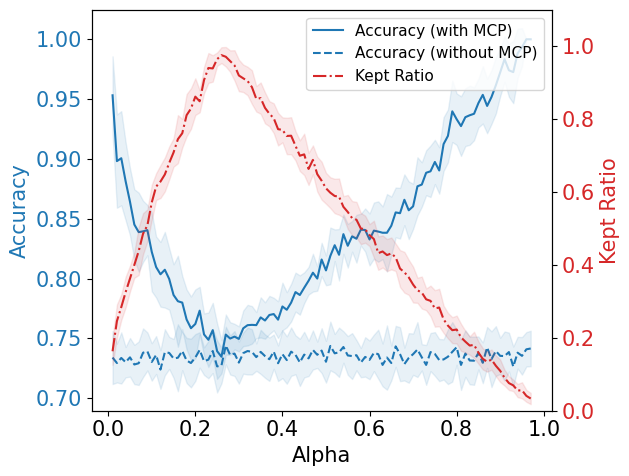

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sem

iterations = 20
alphas = np.arange(0.01, 0.98, 0.01)

filtered_accuracies = []
filtered_lengths = []

all_accuracies = []
kept_ratios = []

all_accuracies_iters = []
filtered_accuracies_iters = []
kept_ratios_iters = []

# combine calibration and test data
X_combined = np.concatenate((X_calib, X_test), axis=0)
y_combined = np.concatenate((y_calib, y_test), axis=0)

for alpha in alphas:
    print(alpha)
    filtered_accuracies_alpha = []
    filtered_lengths_alpha = []
    accuracies = []
    kept_ratios_alpha = []
    
    for _ in range(iterations):
        # split combined data into new calibration and test sets
        X_new_calib, X_new_test, y_new_calib, y_new_test = train_test_split(X_combined, y_combined, test_size=0.5)

        # then use these new sets in the rest of your code
        y_pred_proba_calib = clf.predict_proba(X_new_calib)
        y_pred_proba_test = clf.predict_proba(X_new_test)

        # Calculate the conformity scores
        conformity_scores = y_pred_proba_calib[np.arange(len(y_new_calib)), y_new_calib]

        # Calculate p-values for test set
        p_values = []
        for probas in y_pred_proba_test:
            instance_p_values = [np.mean(proba >= conformity_scores) for proba in probas]
            p_values.append(instance_p_values)
        p_values = np.array(p_values)

        predictions = [(p > alpha).nonzero()[0] for p in p_values]
        filtered_indices = [i for i, prediction in enumerate(predictions) if len(prediction) == 1]
        filtered_y_test = y_new_test[filtered_indices]
        filtered_predictions = [predictions[i][0] for i in filtered_indices]
        correct = np.sum(filtered_y_test == filtered_predictions)
        filtered_accuracy = correct / len(filtered_y_test)
    
        filtered_accuracies_alpha.append(filtered_accuracy)
        filtered_lengths_alpha.append(len(filtered_y_test))
        
        # Calculate accuracy
        y_pred_test = clf.predict(X_new_test)
        accuracy = np.sum(y_pred_test == y_new_test) / len(y_new_test)
        accuracies.append(accuracy)

        # Calculate kept ratio
        kept_ratio = len(filtered_y_test) / len(y_new_test)
        kept_ratios_alpha.append(kept_ratio)
    
    filtered_accuracies.append(np.mean(filtered_accuracies_alpha))
    filtered_lengths.append(np.mean(filtered_lengths_alpha))
    all_accuracies.append(np.mean(accuracies))
    kept_ratios.append(np.mean(kept_ratios_alpha))
    
    filtered_accuracies_iters.append(filtered_accuracies_alpha)
    all_accuracies_iters.append(accuracies)
    kept_ratios_iters.append(kept_ratios_alpha)

# calculate standard deviation
filtered_accuracies_sd = [np.std(acc) for acc in filtered_accuracies_iters]
all_accuracies_sd = [np.std(acc) for acc in all_accuracies_iters]
kept_ratios_sd = [np.std(ratio) for ratio in kept_ratios_iters]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Alpha', fontsize=15)
ax1.set_ylabel('Accuracy', color=color, fontsize=15)
line1, = ax1.plot(alphas, filtered_accuracies, color=color, label='Accuracy (with MCP)')
ax1.fill_between(alphas, np.array(filtered_accuracies) - np.array(filtered_accuracies_sd),
                 np.array(filtered_accuracies) + np.array(filtered_accuracies_sd), color=color, alpha=0.1)
ax1.tick_params(axis='y', labelcolor=color, labelsize=15)

line2, = ax1.plot(alphas, all_accuracies, color='tab:blue', linestyle='--', label='Accuracy (without MCP)')
ax1.fill_between(alphas, np.array(all_accuracies) - np.array(all_accuracies_sd),
                 np.array(all_accuracies) + np.array(all_accuracies_sd), color='tab:blue', alpha=0.1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylim([0, 1.1])
color = 'tab:red'
ax2.set_ylabel('Kept Ratio', color=color, fontsize=15)
line3, = ax2.plot(alphas, kept_ratios, color=color, linestyle='-.', label='Kept Ratio')
ax2.fill_between(alphas, np.array(kept_ratios) - np.array(kept_ratios_sd),
                 np.array(kept_ratios) + np.array(kept_ratios_sd), color=color, alpha=0.1)
ax2.tick_params(axis='y', labelcolor=color, labelsize=15)

fig.tight_layout()
plt.legend(handles=[line1, line2, line3], loc='upper right', fontsize=11)
ax1.tick_params(axis='x', labelsize=15)
plt.savefig('regroup_Accuracy_AUC_MCP.pdf', format='pdf')
plt.show()


## MCC 

0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999
0.11
0.12
0.13
0.14
0.15000000000000002
0.16
0.17
0.18000000000000002
0.19
0.2
0.21000000000000002
0.22
0.23
0.24000000000000002
0.25
0.26
0.27
0.28
0.29000000000000004
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36000000000000004
0.37
0.38
0.39
0.4
0.41000000000000003
0.42000000000000004
0.43
0.44
0.45
0.46
0.47000000000000003
0.48000000000000004
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.5800000000000001
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.6900000000000001
0.7000000000000001
0.7100000000000001
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.8200000000000001
0.8300000000000001
0.8400000000000001
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.9400000000000001
0.9500000000000001
0.9600000000000001
0.97


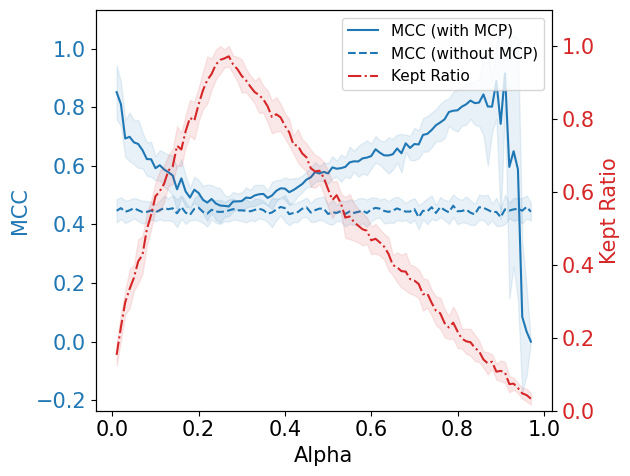

In [154]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import matthews_corrcoef

iterations = 20
alphas = np.arange(0.01, 0.98, 0.01)

filtered_mccs = []
all_mccs = []
kept_ratios = []

filtered_mccs_iters = []
all_mccs_iters = []
kept_ratios_iters = []

# combine calibration and test data
X_combined = np.concatenate((X_calib, X_test), axis=0)
y_combined = np.concatenate((y_calib, y_test), axis=0)

for alpha in alphas:
    print(alpha)
    filtered_mccs_alpha = []
    all_mccs_alpha = []
    kept_ratios_alpha = []
    
    for _ in range(iterations):
        # split combined data into new calibration and test sets
        X_new_calib, X_new_test, y_new_calib, y_new_test = train_test_split(X_combined, y_combined, test_size=0.5)

        # then use these new sets in the rest of your code
        y_pred_proba_calib = clf.predict_proba(X_new_calib)
        y_pred_proba_test = clf.predict_proba(X_new_test)

        # Calculate the conformity scores
        conformity_scores = y_pred_proba_calib[np.arange(len(y_new_calib)), y_new_calib]

        # Calculate p-values for test set
        p_values = []
        for probas in y_pred_proba_test:
            instance_p_values = [np.mean(proba >= conformity_scores) for proba in probas]
            p_values.append(instance_p_values)
        p_values = np.array(p_values)

        predictions = [(p > alpha).nonzero()[0] for p in p_values]
        filtered_indices = [i for i, prediction in enumerate(predictions) if len(prediction) == 1]
        filtered_y_test = y_new_test[filtered_indices]
        filtered_predictions = [predictions[i][0] for i in filtered_indices]

        # Calculate MCC
        mcc_filtered = matthews_corrcoef(filtered_y_test, filtered_predictions)
        filtered_mccs_alpha.append(mcc_filtered)

        # Calculate MCC for all predictions
        y_pred_test = clf.predict(X_new_test)
        mcc = matthews_corrcoef(y_new_test, y_pred_test)
        all_mccs_alpha.append(mcc)

        # Calculate kept ratio
        kept_ratio = len(filtered_y_test) / len(y_new_test)
        kept_ratios_alpha.append(kept_ratio)
    
    filtered_mccs.append(np.mean(filtered_mccs_alpha))
    all_mccs.append(np.mean(all_mccs_alpha))
    kept_ratios.append(np.mean(kept_ratios_alpha))
    
    filtered_mccs_iters.append(filtered_mccs_alpha)
    all_mccs_iters.append(all_mccs_alpha)
    kept_ratios_iters.append(kept_ratios_alpha)

# calculate standard deviation
filtered_mccs_sd = [np.std(mcc) for mcc in filtered_mccs_iters]
all_mccs_sd = [np.std(mcc) for mcc in all_mccs_iters]
kept_ratios_sd = [np.std(ratio) for ratio in kept_ratios_iters]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Alpha', fontsize=15)
ax1.set_ylabel('MCC', color=color, fontsize=15)
line1, = ax1.plot(alphas, filtered_mccs, color=color, label='MCC (with MCP)')
ax1.fill_between(alphas, np.array(filtered_mccs) - np.array(filtered_mccs_sd),
                 np.array(filtered_mccs) + np.array(filtered_mccs_sd), color=color, alpha=0.1)
ax1.tick_params(axis='y', labelcolor=color, labelsize=15)

line2, = ax1.plot(alphas, all_mccs, color='tab:blue', linestyle='--', label='MCC (without MCP)')
ax1.fill_between(alphas, np.array(all_mccs) - np.array(all_mccs_sd),
                 np.array(all_mccs) + np.array(all_mccs_sd), color='tab:blue', alpha=0.1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylim([0, 1.1])
color = 'tab:red'
ax2.set_ylabel('Kept Ratio', color=color, fontsize=15)
line3, = ax2.plot(alphas, kept_ratios, color=color, linestyle='-.', label='Kept Ratio')
ax2.fill_between(alphas, np.array(kept_ratios) - np.array(kept_ratios_sd),
                 np.array(kept_ratios) + np.array(kept_ratios_sd), color=color, alpha=0.1)
ax2.tick_params(axis='y', labelcolor=color, labelsize=15)

fig.tight_layout()
plt.legend(handles=[line1, line2, line3], loc='upper right', fontsize=11)
ax1.tick_params(axis='x', labelsize=15)
plt.savefig('regroup_MCC_MCP.pdf', format='pdf')
plt.show()


## sensitivity-recall

0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999
0.11
0.12
0.13
0.14
0.15000000000000002
0.16
0.17
0.18000000000000002
0.19
0.2
0.21000000000000002
0.22
0.23
0.24000000000000002
0.25
0.26
0.27
0.28
0.29000000000000004
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36000000000000004
0.37
0.38
0.39
0.4
0.41000000000000003
0.42000000000000004
0.43
0.44
0.45
0.46
0.47000000000000003
0.48000000000000004
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.5800000000000001
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.6900000000000001
0.7000000000000001
0.7100000000000001
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.8200000000000001
0.8300000000000001
0.8400000000000001
0.85
0.86
0.87
0.88
0.89
0.9
0.91


C:\Users\Localadmin_weikaixi\anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Localadmin_weikaixi\anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.92
0.93


C:\Users\Localadmin_weikaixi\anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Localadmin_weikaixi\anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Localadmin_weikaixi\anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Localadmin_weikaixi\anaconda3\envs\py37\lib\site-packages\skl

0.9400000000000001


C:\Users\Localadmin_weikaixi\anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Localadmin_weikaixi\anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Localadmin_weikaixi\anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Localadmin_weikaixi\anaconda3\envs\py37\lib\site-packages\skl

0.9500000000000001


C:\Users\Localadmin_weikaixi\anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Localadmin_weikaixi\anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Localadmin_weikaixi\anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Localadmin_weikaixi\anaconda3\envs\py37\lib\site-packages\skl

0.9600000000000001


C:\Users\Localadmin_weikaixi\anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Localadmin_weikaixi\anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Localadmin_weikaixi\anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Localadmin_weikaixi\anaconda3\envs\py37\lib\site-packages\skl

0.97


C:\Users\Localadmin_weikaixi\anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Localadmin_weikaixi\anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Localadmin_weikaixi\anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Localadmin_weikaixi\anaconda3\envs\py37\lib\site-packages\skl

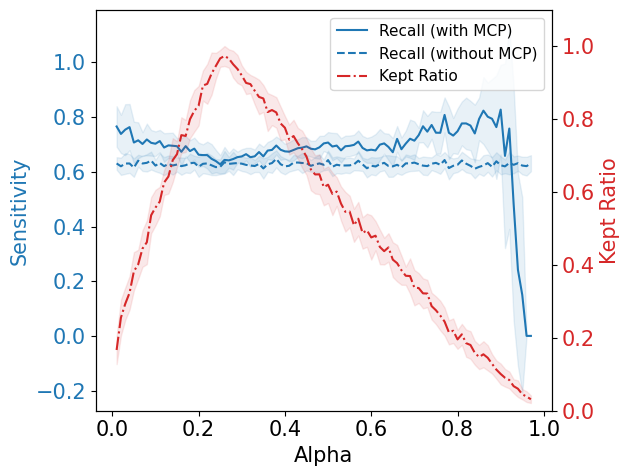

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import recall_score

iterations = 20
alphas = np.arange(0.01, 0.98, 0.01)

filtered_recalls = []
all_recalls = []
kept_ratios = []

filtered_recalls_iters = []
all_recalls_iters = []
kept_ratios_iters = []

# combine calibration and test data
X_combined = np.concatenate((X_calib, X_test), axis=0)
y_combined = np.concatenate((y_calib, y_test), axis=0)

for alpha in alphas:
    print(alpha)
    filtered_recalls_alpha = []
    all_recalls_alpha = []
    kept_ratios_alpha = []
    
    for _ in range(iterations):
        # split combined data into new calibration and test sets
        X_new_calib, X_new_test, y_new_calib, y_new_test = train_test_split(X_combined, y_combined, test_size=0.5)

        # then use these new sets in the rest of your code
        y_pred_proba_calib = clf.predict_proba(X_new_calib)
        y_pred_proba_test = clf.predict_proba(X_new_test)

        # Calculate the conformity scores
        conformity_scores = y_pred_proba_calib[np.arange(len(y_new_calib)), y_new_calib]

        # Calculate p-values for test set
        p_values = []
        for probas in y_pred_proba_test:
            instance_p_values = [np.mean(proba >= conformity_scores) for proba in probas]
            p_values.append(instance_p_values)
        p_values = np.array(p_values)

        predictions = [(p > alpha).nonzero()[0] for p in p_values]
        filtered_indices = [i for i, prediction in enumerate(predictions) if len(prediction) == 1]
        filtered_y_test = y_new_test[filtered_indices]
        filtered_predictions = [predictions[i][0] for i in filtered_indices]

        # Calculate Recall
        recall_filtered = recall_score(filtered_y_test, filtered_predictions)
        filtered_recalls_alpha.append(recall_filtered)

        # Calculate Recall for all predictions
        y_pred_test = clf.predict(X_new_test)
        recall = recall_score(y_new_test, y_pred_test)
        all_recalls_alpha.append(recall)

        # Calculate kept ratio
        kept_ratio = len(filtered_y_test) / len(y_new_test)
        kept_ratios_alpha.append(kept_ratio)
    
    filtered_recalls.append(np.mean(filtered_recalls_alpha))
    all_recalls.append(np.mean(all_recalls_alpha))
    kept_ratios.append(np.mean(kept_ratios_alpha))
    
    filtered_recalls_iters.append(filtered_recalls_alpha)
    all_recalls_iters.append(all_recalls_alpha)
    kept_ratios_iters.append(kept_ratios_alpha)

# calculate standard deviation
filtered_recalls_sd = [np.std(recall) for recall in filtered_recalls_iters]
all_recalls_sd = [np.std(recall) for recall in all_recalls_iters]
kept_ratios_sd = [np.std(ratio) for ratio in kept_ratios_iters]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Alpha', fontsize=15)
ax1.set_ylabel('Sensitivity', color=color, fontsize=15)
line1, = ax1.plot(alphas, filtered_recalls, color=color, label='Recall (with MCP)')
ax1.fill_between(alphas, np.array(filtered_recalls) - np.array(filtered_recalls_sd),
                 np.array(filtered_recalls) + np.array(filtered_recalls_sd), color=color, alpha=0.1)
ax1.tick_params(axis='y', labelcolor=color, labelsize=15)

line2, = ax1.plot(alphas, all_recalls, color='tab:blue', linestyle='--', label='Recall (without MCP)')
ax1.fill_between(alphas, np.array(all_recalls) - np.array(all_recalls_sd),
                 np.array(all_recalls) + np.array(all_recalls_sd), color='tab:blue', alpha=0.1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylim([0, 1.1])
color = 'tab:red'
ax2.set_ylabel('Kept Ratio', color=color, fontsize=15)
line3, = ax2.plot(alphas, kept_ratios, color=color, linestyle='-.', label='Kept Ratio')
ax2.fill_between(alphas, np.array(kept_ratios) - np.array(kept_ratios_sd),
                 np.array(kept_ratios) + np.array(kept_ratios_sd), color=color, alpha=0.1)
ax2.tick_params(axis='y', labelcolor=color, labelsize=15)

fig.tight_layout()
plt.legend(handles=[line1, line2, line3], loc='upper right', fontsize=11)
ax1.tick_params(axis='x', labelsize=15)
plt.savefig('regroup_Sensitivity_MCP.pdf', format='pdf')
plt.show()


## specificity 

0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999
0.11
0.12
0.13
0.14
0.15000000000000002
0.16
0.17
0.18000000000000002
0.19
0.2
0.21000000000000002
0.22
0.23
0.24000000000000002
0.25
0.26
0.27
0.28
0.29000000000000004
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36000000000000004
0.37
0.38
0.39
0.4
0.41000000000000003
0.42000000000000004
0.43
0.44
0.45
0.46
0.47000000000000003
0.48000000000000004
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.5800000000000001
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.6900000000000001
0.7000000000000001
0.7100000000000001
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.8200000000000001
0.8300000000000001
0.8400000000000001
0.85
0.86
0.87
0.88
0.89
0.9


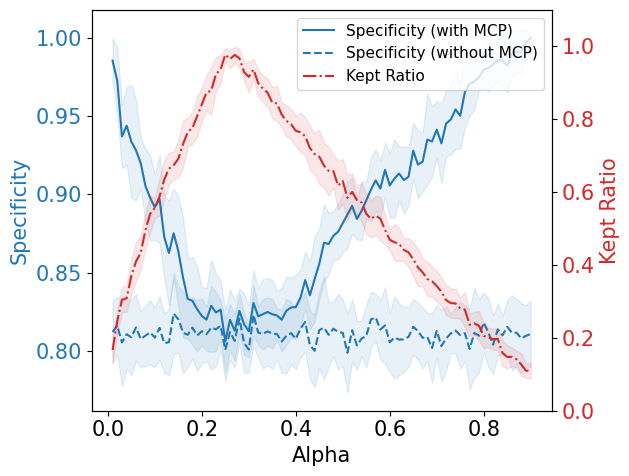

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn+fp)
    return specificity

iterations = 20
alphas = np.arange(0.01, 0.91, 0.01)

filtered_specificities = []
all_specificities = []
kept_ratios = []

filtered_specificities_iters = []
all_specificities_iters = []
kept_ratios_iters = []

# combine calibration and test data
X_combined = np.concatenate((X_calib, X_test), axis=0)
y_combined = np.concatenate((y_calib, y_test), axis=0)

for alpha in alphas:
    print(alpha)
    filtered_specificities_alpha = []
    all_specificities_alpha = []
    kept_ratios_alpha = []
    
    for _ in range(iterations):
        # split combined data into new calibration and test sets
        X_new_calib, X_new_test, y_new_calib, y_new_test = train_test_split(X_combined, y_combined, test_size=0.5)

        # then use these new sets in the rest of your code
        y_pred_proba_calib = clf.predict_proba(X_new_calib)
        y_pred_proba_test = clf.predict_proba(X_new_test)

        # Calculate the conformity scores
        conformity_scores = y_pred_proba_calib[np.arange(len(y_new_calib)), y_new_calib]

        # Calculate p-values for test set
        p_values = []
        for probas in y_pred_proba_test:
            instance_p_values = [np.mean(proba >= conformity_scores) for proba in probas]
            p_values.append(instance_p_values)
        p_values = np.array(p_values)

        predictions = [(p > alpha).nonzero()[0] for p in p_values]
        filtered_indices = [i for i, prediction in enumerate(predictions) if len(prediction) == 1]
        filtered_y_test = y_new_test[filtered_indices]
        filtered_predictions = [predictions[i][0] for i in filtered_indices]

        # Calculate Specificity
        specificity_filtered = specificity_score(filtered_y_test, filtered_predictions)
        filtered_specificities_alpha.append(specificity_filtered)

        # Calculate Specificity for all predictions
        y_pred_test = clf.predict(X_new_test)
        specificity = specificity_score(y_new_test, y_pred_test)
        all_specificities_alpha.append(specificity)

        # Calculate kept ratio
        kept_ratio = len(filtered_y_test) / len(y_new_test)
        kept_ratios_alpha.append(kept_ratio)
    
    filtered_specificities.append(np.mean(filtered_specificities_alpha))
    all_specificities.append(np.mean(all_specificities_alpha))
    kept_ratios.append(np.mean(kept_ratios_alpha))
    
    filtered_specificities_iters.append(filtered_specificities_alpha)
    all_specificities_iters.append(all_specificities_alpha)
    kept_ratios_iters.append(kept_ratios_alpha)

# calculate standard deviation
filtered_specificities_sd = [np.std(specificity) for specificity in filtered_specificities_iters]
all_specificities_sd = [np.std(specificity) for specificity in all_specificities_iters]
kept_ratios_sd = [np.std(ratio) for ratio in kept_ratios_iters]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Alpha', fontsize=15)
ax1.set_ylabel('Specificity', color=color, fontsize=15)
line1, = ax1.plot(alphas, filtered_specificities, color=color, label='Specificity (with MCP)')
ax1.fill_between(alphas, np.array(filtered_specificities) - np.array(filtered_specificities_sd),
                 np.array(filtered_specificities) + np.array(filtered_specificities_sd), color=color, alpha=0.1)
ax1.tick_params(axis='y', labelcolor=color, labelsize=15)

line2, = ax1.plot(alphas, all_specificities, color='tab:blue', linestyle='--', label='Specificity (without MCP)')
ax1.fill_between(alphas, np.array(all_specificities) - np.array(all_specificities_sd),
                 np.array(all_specificities) + np.array(all_specificities_sd), color='tab:blue', alpha=0.1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylim([0, 1.1])
color = 'tab:red'
ax2.set_ylabel('Kept Ratio', color=color, fontsize=15)
line3, = ax2.plot(alphas, kept_ratios, color=color, linestyle='-.', label='Kept Ratio')
ax2.fill_between(alphas, np.array(kept_ratios) - np.array(kept_ratios_sd),
                 np.array(kept_ratios) + np.array(kept_ratios_sd), color=color, alpha=0.1)
ax2.tick_params(axis='y', labelcolor=color, labelsize=15)

fig.tight_layout()
plt.legend(handles=[line1, line2, line3], loc='upper right', fontsize=11)
ax1.tick_params(axis='x', labelsize=15)
plt.savefig('regroup_SepcificityMCP.pdf', format='pdf')
plt.show()


## ROCAUC 

0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999
0.11
0.12
0.13
0.14
0.15000000000000002
0.16
0.17
0.18000000000000002
0.19
0.2
0.21000000000000002
0.22
0.23
0.24000000000000002
0.25
0.26
0.27
0.28
0.29000000000000004
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36000000000000004
0.37
0.38
0.39
0.4
0.41000000000000003
0.42000000000000004
0.43
0.44
0.45
0.46
0.47000000000000003
0.48000000000000004
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.5800000000000001
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.6900000000000001
0.7000000000000001
0.7100000000000001
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.8200000000000001
0.8300000000000001
0.8400000000000001
0.85
0.86
0.87
0.88
0.89
0.9


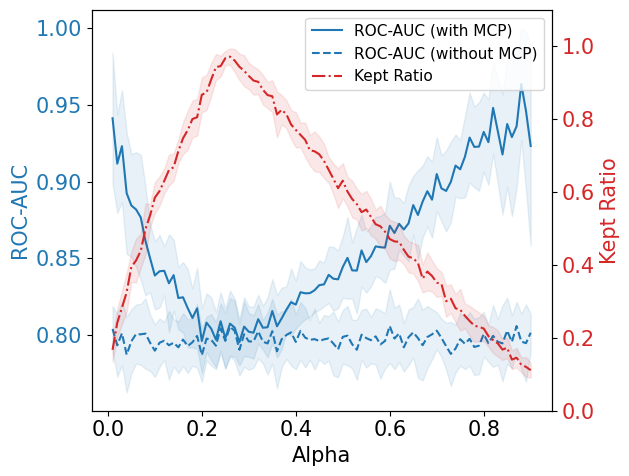

In [23]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score

iterations = 20
alphas = np.arange(0.01, 0.91, 0.01)

filtered_rocaucs = []
all_rocaucs = []
kept_ratios = []

filtered_rocaucs_iters = []
all_rocaucs_iters = []
kept_ratios_iters = []








# combine calibration and test data
X_combined = np.concatenate((X_calib, X_test), axis=0)
y_combined = np.concatenate((y_calib, y_test), axis=0)

for alpha in alphas:
    print(alpha)
    filtered_rocaucs_alpha = []
    all_rocaucs_alpha = []
    kept_ratios_alpha = []
    
    for _ in range(iterations):
        # split combined data into new calibration and test sets
        X_new_calib, X_new_test, y_new_calib, y_new_test = train_test_split(X_combined, y_combined, test_size=0.5)

        # then use these new sets in the rest of your code
        y_pred_proba_calib = clf.predict_proba(X_new_calib)
        y_pred_proba_test = clf.predict_proba(X_new_test)

        # Calculate the conformity scores
        conformity_scores = y_pred_proba_calib[np.arange(len(y_new_calib)), y_new_calib]

               # Calculate p-values for test set
        p_values = []
        for probas in y_pred_proba_test:
            instance_p_values = [np.mean(proba >= conformity_scores) for proba in probas]
            p_values.append(instance_p_values)
        p_values = np.array(p_values)

        predictions = [(p > alpha).nonzero()[0] for p in p_values]
        filtered_indices = [i for i, prediction in enumerate(predictions) if len(prediction) == 1]
        
        filtered_y_test = y_new_test[filtered_indices]
        filtered_predictions = y_pred_proba_test[filtered_indices][:,1]

        # Calculate ROC AUC
        rocauc_filtered = roc_auc_score(filtered_y_test, filtered_predictions)
        filtered_rocaucs_alpha.append(rocauc_filtered)

        # Calculate ROC AUC for all predictions
        rocauc = roc_auc_score(y_new_test, y_pred_proba_test[:,1])
        all_rocaucs_alpha.append(rocauc)

        # Calculate kept ratio
        kept_ratio = len(filtered_y_test) / len(y_new_test)
        kept_ratios_alpha.append(kept_ratio)
    
    filtered_rocaucs.append(np.mean(filtered_rocaucs_alpha))
    all_rocaucs.append(np.mean(all_rocaucs_alpha))
    kept_ratios.append(np.mean(kept_ratios_alpha))
    
    filtered_rocaucs_iters.append(filtered_rocaucs_alpha)
    all_rocaucs_iters.append(all_rocaucs_alpha)
    kept_ratios_iters.append(kept_ratios_alpha)

# calculate standard deviation
filtered_rocaucs_sd = [np.std(rocauc) for rocauc in filtered_rocaucs_iters]
all_rocaucs_sd = [np.std(rocauc) for rocauc in all_rocaucs_iters]
kept_ratios_sd = [np.std(ratio) for ratio in kept_ratios_iters]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Alpha', fontsize=15)
ax1.set_ylabel('ROC-AUC', color=color, fontsize=15)
line1, = ax1.plot(alphas, filtered_rocaucs, color=color, label='ROC-AUC (with MCP)')
ax1.fill_between(alphas, np.array(filtered_rocaucs) - np.array(filtered_rocaucs_sd),
                 np.array(filtered_rocaucs) + np.array(filtered_rocaucs_sd), color=color, alpha=0.1)
ax1.tick_params(axis='y', labelcolor=color, labelsize=15)

line2, = ax1.plot(alphas, all_rocaucs, color='tab:blue', linestyle='--', label='ROC-AUC (without MCP)')
ax1.fill_between(alphas, np.array(all_rocaucs) - np.array(all_rocaucs_sd),
                 np.array(all_rocaucs) + np.array(all_rocaucs_sd), color='tab:blue', alpha=0.1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylim([0, 1.1])
color = 'tab:red'
ax2.set_ylabel('Kept Ratio', color=color, fontsize=15)
line3, = ax2.plot(alphas, kept_ratios, color=color, linestyle='-.', label='Kept Ratio')
ax2.fill_between(alphas, np.array(kept_ratios) - np.array(kept_ratios_sd),
                 np.array(kept_ratios) + np.array(kept_ratios_sd), color=color, alpha=0.1)
ax2.tick_params(axis='y', labelcolor=color, labelsize=15)

fig.tight_layout()
plt.legend(handles=[line1, line2, line3], loc='upper right', fontsize=11)
ax1.tick_params(axis='x', labelsize=15)
plt.savefig('regroup_ROCAUC_MCP.pdf', format='pdf')
plt.show()


0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999
0.11
0.12
0.13
0.14
0.15000000000000002
0.16
0.17
0.18000000000000002
0.19
0.2
0.21000000000000002
0.22
0.23
0.24000000000000002
0.25
0.26
0.27
0.28
0.29000000000000004
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36000000000000004
0.37
0.38
0.39
0.4
0.41000000000000003
0.42000000000000004
0.43
0.44
0.45
0.46
0.47000000000000003
0.48000000000000004
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.5800000000000001
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.6900000000000001
0.7000000000000001
0.7100000000000001
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.8200000000000001
0.8300000000000001
0.8400000000000001
0.85
0.86
0.87
0.88
0.89
0.9


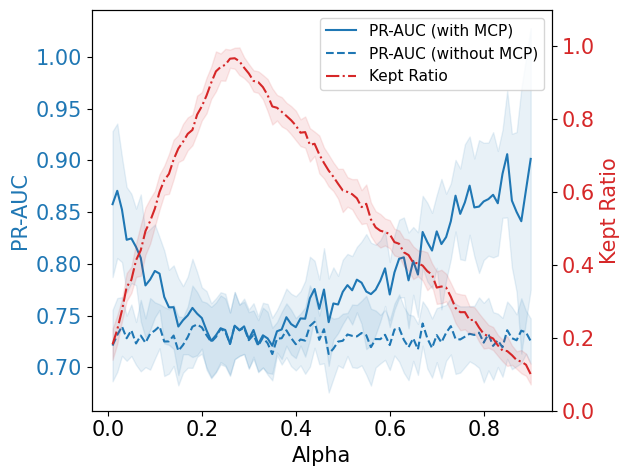

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve

iterations = 20
alphas = np.arange(0.01, 0.91, 0.01)

filtered_praucs = []
all_praucs = []
kept_ratios = []

filtered_praucs_iters = []
all_praucs_iters = []
kept_ratios_iters = []

# combine calibration and test data
X_combined = np.concatenate((X_calib, X_test), axis=0)
y_combined = np.concatenate((y_calib, y_test), axis=0)

for alpha in alphas:
    print(alpha)
    filtered_praucs_alpha = []
    all_praucs_alpha = []
    kept_ratios_alpha = []

    for _ in range(iterations):
        # split combined data into new calibration and test sets
        X_new_calib, X_new_test, y_new_calib, y_new_test = train_test_split(X_combined, y_combined, test_size=0.5)

        # then use these new sets in the rest of your code
        y_pred_proba_calib = clf.predict_proba(X_new_calib)
        y_pred_proba_test = clf.predict_proba(X_new_test)

        # Calculate the conformity scores
        conformity_scores = y_pred_proba_calib[np.arange(len(y_new_calib)), y_new_calib]

        # Calculate p-values for test set
        p_values = []
        for probas in y_pred_proba_test:
            instance_p_values = [np.mean(proba >= conformity_scores) for proba in probas]
            p_values.append(instance_p_values)
        p_values = np.array(p_values)

        predictions = [(p > alpha).nonzero()[0] for p in p_values]
        filtered_indices = [i for i, prediction in enumerate(predictions) if len(prediction) == 1]

        filtered_y_test = y_new_test[filtered_indices]
        filtered_predictions = y_pred_proba_test[filtered_indices][:,1]

        # Calculate PR AUC
        prauc_filtered = average_precision_score(filtered_y_test, filtered_predictions)
        filtered_praucs_alpha.append(prauc_filtered)

        # Calculate PR AUC for all predictions
        prauc = average_precision_score(y_new_test, y_pred_proba_test[:,1])
        all_praucs_alpha.append(prauc)

        # Calculate kept ratio
        kept_ratio = len(filtered_y_test) / len(y_new_test)
        kept_ratios_alpha.append(kept_ratio)
    
    filtered_praucs.append(np.mean(filtered_praucs_alpha))
    all_praucs.append(np.mean(all_praucs_alpha))
    kept_ratios.append(np.mean(kept_ratios_alpha))

    filtered_praucs_iters.append(filtered_praucs_alpha)
    all_praucs_iters.append(all_praucs_alpha)
    kept_ratios_iters.append(kept_ratios_alpha)

# calculate standard deviation
filtered_praucs_sd = [np.std(prauc) for prauc in filtered_praucs_iters]
all_praucs_sd = [np.std(prauc) for prauc in all_praucs_iters]
kept_ratios_sd = [np.std(ratio) for ratio in kept_ratios_iters]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Alpha', fontsize=15)
ax1.set_ylabel('PR-AUC', color=color, fontsize=15)
line1, = ax1.plot(alphas, filtered_praucs, color=color, label='PR-AUC (with MCP)')
ax1.fill_between(alphas, np.array(filtered_praucs) - np.array(filtered_praucs_sd),
                 np.array(filtered_praucs) + np.array(filtered_praucs_sd), color=color, alpha=0.1)
ax1.tick_params(axis='y', labelcolor=color, labelsize=15)

line2, = ax1.plot(alphas, all_praucs, color='tab:blue', linestyle='--', label='PR-AUC (without MCP)')
ax1.fill_between(alphas, np.array(all_praucs) - np.array(all_praucs_sd),
                 np.array(all_praucs) + np.array(all_praucs_sd), color='tab:blue', alpha=0.1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylim([0, 1.1])
color = 'tab:red'
ax2.set_ylabel('Kept Ratio', color=color, fontsize=15)
line3, = ax2.plot(alphas, kept_ratios, color=color, linestyle='-.', label='Kept Ratio')
ax2.fill_between(alphas, np.array(kept_ratios) - np.array(kept_ratios_sd),
                 np.array(kept_ratios) + np.array(kept_ratios_sd), color=color, alpha=0.1)
ax2.tick_params(axis='y', labelcolor=color, labelsize=15)

fig.tight_layout()
plt.legend(handles=[line1, line2, line3], loc='upper right', fontsize=11)
ax1.tick_params(axis='x', labelsize=15)
plt.savefig('regroup_PRAUC_MCP.pdf', format='pdf')
plt.show()
